In [37]:
import pandas as pd
import numpy as np
import requests
import re

In [3]:
df = pd.read_csv('dataset/final_hltb.csv')
df.head()

,Unnamed: 0,gameName,genre,reviewScore,playTime
0,0,Dying Light,Action,78,96.82
1,1,Grand Theft Auto IV,Action,82,134.66
2,2,The Witcher,Role-Playing,77,35.55
3,3,Half-Life,Shooter,84,24.68
4,4,Far Cry 3,Shooter,83,108.12


Q4

主导roleplaying评分高的主要因素是什么 ?

In [9]:
def search_steam_appid(game_name):

    url = f"https://steamcommunity.com/actions/SearchApps/{game_name}"
    try:
        resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = resp.json()

        if len(data) == 0:
            return None  # 找不到

        # 返回最匹配的一项
        return data[0].get("appid", None)

    except Exception as e:
        print("Error:", e)
        return None

# df["appID"] = df["gameName"].apply(search_steam_appid)     
# df.head()  

In [ ]:

def fetch_steam_reviews(appid, num=100):
    """
    从 Steam 官方 appreviews API 获取 num 条英文最新评论
    """
    url = f"https://store.steampowered.com/appreviews/{appid}"
    
    params = {  
        "json": 1,
        "language": "english",
        "filter": "recent",
        "num_per_page": num,
        "cursor": "*"
    }

    resp = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"})
    data = resp.json()
    
    reviews = data.get("reviews", [])
    # 只保留我们关心的字段
    rows = []
    for r in reviews[:num]:
        rows.append({
            "appid": appid,
            "recommend": r.get("voted_up"),
            "review_text": r.get("review"),
        })
    return pd.DataFrame(rows)

In [18]:
# —— Step 3: 输入游戏名称 → 自动返回评论 ——
def fetch_reviews_by_name(game_name, num=100):
    appid = search_steam_appid(game_name)

    if appid is None:
        print(f"❌ 无法获取 {game_name} 的 AppID")
        return pd.DataFrame()

    print(f"🔍 找到游戏：{game_name} → AppID = {appid}")

    return fetch_steam_reviews(appid, num=num)

comments_df = fetch_reviews_by_name("Dying Light", 100)
comments_df

🔍 找到游戏：Dying Light → AppID = 239140


,appid,recommend,review_text
0,239140,True,Best game I've ever played
1,239140,True,"Incredible game, they simply nailed the genre."
2,239140,True,PJ5118 Likes this game
3,239140,True,Parkour is amazing for its time
4,239140,True,gam gud thumb
...,...,...,...
95,239140,False,"After a while, the missions started to feel li..."
96,239140,True,Dying Light feels like the kind of game that g...
97,239140,True,Very well polished\r\nFew non-fighting games h...
98,239140,True,parkour you say.... with ragdoll physics?????


In [21]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# 第一次用需要下载词典
nltk.download('vader_lexicon')

# 初始化一次就好
sia = SentimentIntensityAnalyzer()

def get_sentiment_score_vader(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    # compound ∈ [-1, 1]，越大越正面
    return sia.polarity_scores(text)['compound']

def label_sentiment(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    elif score <= neg_th:
        return "negative"
    else:
        return "neutral"


comments_df["sentiment_score"] = comments_df["review_text"].apply(get_sentiment_score_vader)
comments_df["sentiment_label"] = comments_df["sentiment_score"].apply(label_sentiment)
comments_df.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,appid,recommend,review_text,sentiment_score,sentiment_label
0,239140,True,Best game I've ever played,0.7650,positive
1,239140,True,"Incredible game, they simply nailed the genre.",0.0000,neutral
2,239140,True,PJ5118 Likes this game,0.4215,positive
3,239140,True,Parkour is amazing for its time,0.5859,positive
4,239140,True,gam gud thumb,0.0000,neutral


In [25]:
summary_df = comments_df.groupby("sentiment_label").agg(
    count=("sentiment_label", "size"),
    avg_sentiment=("sentiment_score", "mean"),
    recommend_rate=("recommend", "mean")
).reset_index()

summary_df["percentage"] = (summary_df["count"] / summary_df["count"].sum()).round(4)
summary_df["avg_sentiment"] = summary_df["avg_sentiment"].round(4)
summary_df["recommend_rate"] = summary_df["recommend_rate"].round(4)

summary_df

,sentiment_label,count,avg_sentiment,recommend_rate,percentage
0,negative,11,-0.4698,0.7273,0.11
1,neutral,29,0.0020,0.9310,0.29
2,positive,60,0.6426,0.9500,0.60


In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/leo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
positive_text = " ".join(comments_df[comments_df["sentiment_label"] == "positive"]["review_text"].astype(str))
negative_text = " ".join(comments_df[comments_df["sentiment_label"] == "negative"]["review_text"].astype(str))

In [28]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # 小写
    text = re.sub(r"[^a-z\s]", "", text)  # 保留字母和空格
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)


In [29]:
positive_clean = clean_text(positive_text)
negative_clean = clean_text(negative_text)


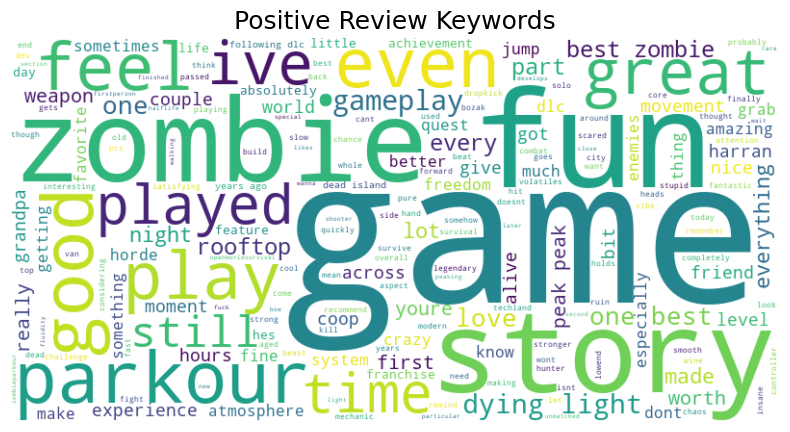

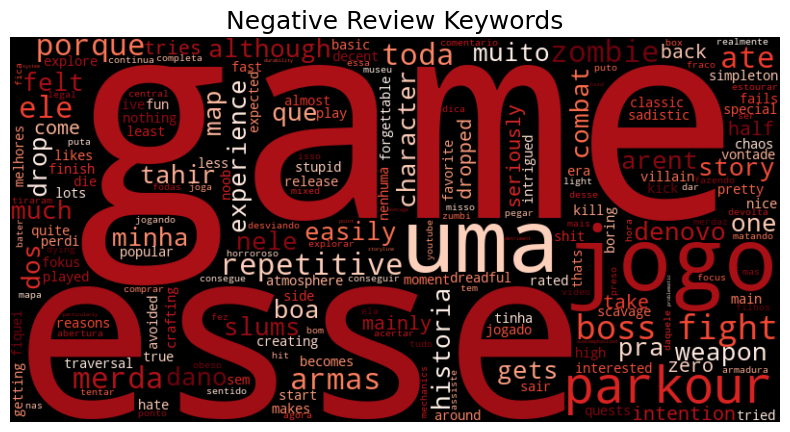

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, sentiment="positive"):

    # # 默认要过滤的词
    # default_remove = ["game", "games"]

    # # -------- 文本预处理：删除指定词汇 --------
    # cleaned_text = text.lower()
    # for w in default_remove:
    #     cleaned_text = re.sub(rf"\b{w}\b", "", cleaned_text)

    # 自动判断颜色风格
    if sentiment.lower() == "positive":
        wc = WordCloud(
            width=800,
            height=400,
            background_color="white"
        ).generate(text)

        title = "Positive Review Keywords"
        title_color = "black"

    else:
        wc = WordCloud(
            width=800,
            height=400,
            background_color="black",
            colormap="Reds"
        ).generate(text)

        title = "Negative Review Keywords"
        title_color = "black"

    # ---- Plot ----
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=18, color=title_color)
    plt.show()


generate_wordcloud(positive_clean, sentiment="positive")

generate_wordcloud(negative_clean, sentiment="negative")

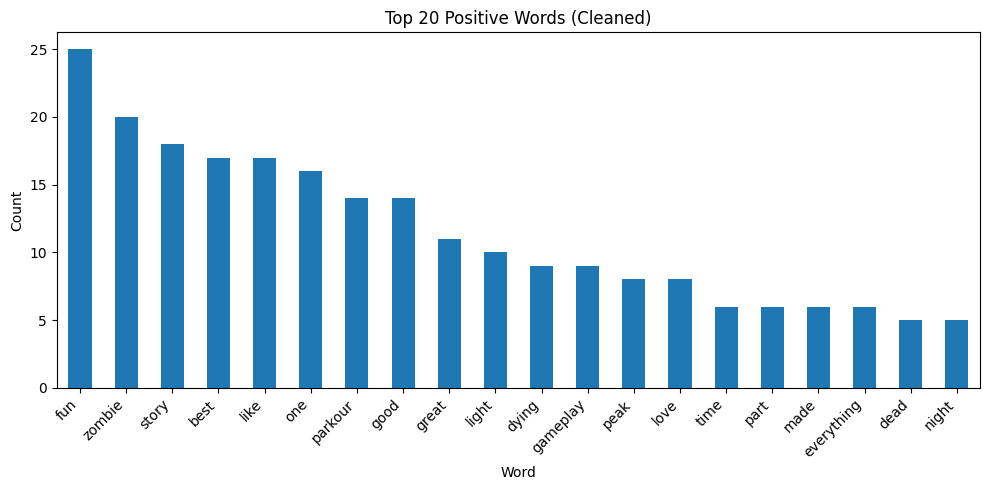

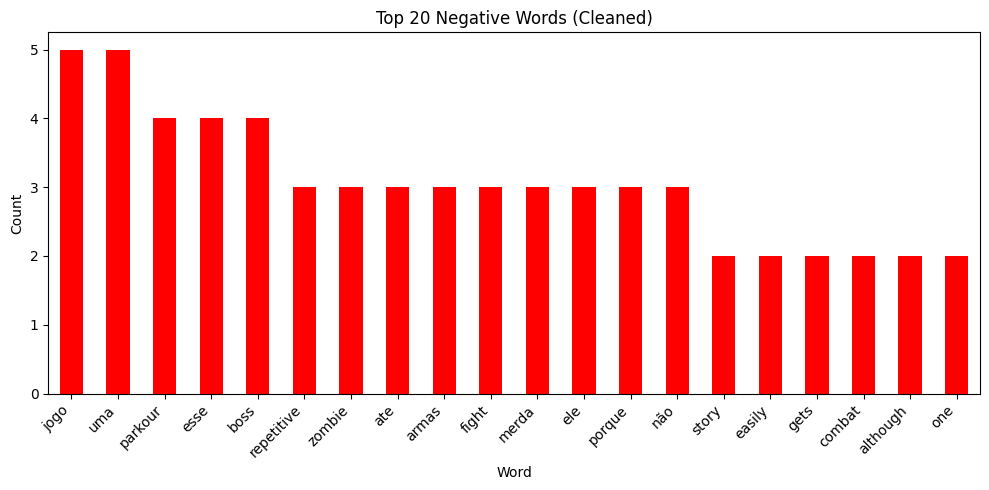

In [54]:
from collections import Counter
from nltk.corpus import stopwords
import string

# 1. 准备停用词 + 自定义要去掉的词
stop_words = set(stopwords.words("english"))
custom_stop = {
    "game", "games", "play", "played", "playing",   # 你不想要的
    "u", "im", "ive", "feel", "even", "ever", "much",
    "many", "still", "feels", "get", "lot", "every",
    "year", "years", "really"    # 口语缩写也可以顺便丢掉
}
all_stop = stop_words | custom_stop

def clean_and_tokenise(text):
    if not text:
        return []
    tokens = []
    for w in text.split():
        w = w.lower().strip(string.punctuation)
        # 去掉空串、停用词、纯数字、长度太短的词
        if (w 
            and w not in all_stop 
            and not w.isdigit() 
            and len(w) > 2):
            tokens.append(w)
    return tokens

# 2. 正负面文本清洗 + 统计
pos_tokens = clean_and_tokenise(positive_text)
neg_tokens = clean_and_tokenise(negative_text)

pos_words = Counter(pos_tokens).most_common(20)
neg_words = Counter(neg_tokens).most_common(20)

# 3. 画正面 top 20
pd.DataFrame(pos_words, columns=["word","count"]).plot(
    kind="bar", x="word", legend=False, figsize=(10,5)
)
plt.title("Top 20 Positive Words (Cleaned)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 4. 画负面 top 20（如果你也想画）
pd.DataFrame(neg_words, columns=["word","count"]).plot(
    kind="bar", x="word", color="red", legend=False, figsize=(10,5)
)
plt.title("Top 20 Negative Words (Cleaned)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
